# Problem Definition:

A bank's credit card department is one of the top adopters of data science. A top focus for the bank has always been acquiring new credit card customers. Giving out credit cards without doing proper research or evaluating applicants' creditworthiness is quite risky. The credit card department has been using a data-driven system for credit assessment called Credit Scoring for many years, and the model is known as an application scorecard. A credit card application's cutoff value is determined using the application scorecard, which also aids in estimating the applicant's level of risk. This decision is made based on strategic priority at a given time.


Customers must fill out a form, either physically or online, to apply for a credit card. The application data is used to evaluate the applicant's creditworthiness. The decision is made using the application data in addition to the Credit Bureau Score, such as the FICO Score in the US or the CIBIL Score in India, and other internal information on the applicants. Additionally, the banks are rapidly taking a lot of outside data into account to enhance the caliber of credit judgements.

Features name: (Credit_Card.csv)
- Ind_ID: Client ID
- Gender: Gender information
- Car_owner: Having car or not
- Propert_owner: Having property or not
- Children: Count of children
- Annual_income: Annual income
- Type_Income: Income type
- Education: Education level
- Marital_status: Marital_status
- Housing_type: Living style
- Birthday_count: Use backward count from current day (0), -1 means yesterday.
- Employed_days: Start date of employment. Use backward count from current day (0). Positive value means, individual is currently unemployed.
- Mobile_phone: Any mobile phone
- Work_phone: Any work phone
- Phone: Any phone number
- EMAIL_ID: Any email ID
- Type_Occupation: Occupation
- Family_Members: Family size

Another data set (Credit_card_label.csv) contains two key pieces of information
- ID: The joining key between application data and credit status data, same is Ind_ID
- Label: 0 is application approved and 1 is application rejected. 

# Dataset:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [2]:
df1 = pd.read_csv('Credit_card.csv')

In [3]:
df1.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [4]:
df2 = pd.read_csv('Credit_card_label.csv')

In [5]:
df2.head()

,Ind_ID,label
0,5008827,1
1,5009744,1
2,5009746,1
3,5009749,1
4,5009752,1


In [6]:
df1.shape, df2.shape

((1548, 18), (1548, 2))

In [7]:
df = pd.merge(left=df1, right=df2, how='inner', on='Ind_ID')

# Data Cleaning:

Removing inconsistencies, missing values, and errors.

In [8]:
df.drop(columns='Ind_ID', inplace=True)

In [9]:
df.isna().sum()

GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
label                0
dtype: int64

In [10]:
df.drop(columns=['Type_Occupation', 'GENDER', 
                 'Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID'], inplace=True)

In [11]:
df.isna().sum()

Car_Owner          0
Propert_Owner      0
CHILDREN           0
Annual_income     23
Type_Income        0
EDUCATION          0
Marital_status     0
Housing_type       0
Birthday_count    22
Employed_days      0
Family_Members     0
label              0
dtype: int64

In [12]:
df.Annual_income.fillna(df.Annual_income.mean(), inplace=True)
df.Birthday_count.fillna(df.Birthday_count.mean(), inplace=True)

Not removing any duplicate values because for classification models does not get affected... also the dataset records are less.

# EDA & Feature Engineering:

Handling outliers

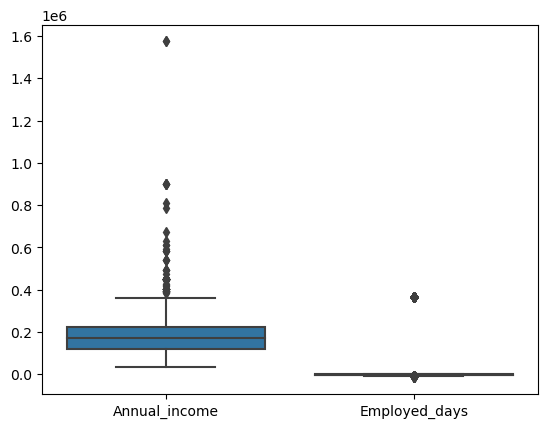

In [13]:
sns.boxplot(df[['Annual_income', 'Employed_days', ]]);

In [14]:
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    Lower = Q1 - (1.5*IQR)
    Upper = Q3 + (1.5*IQR)
    return Lower, Upper

In [15]:
Annual_Income_IQR = IQR(df['Annual_income'])
Employee_days_IQR = IQR(df['Employed_days'])

In [16]:
df['Annual_income'].clip(lower=Annual_Income_IQR[0], upper=Annual_Income_IQR[1], inplace=True)
df['Employed_days'].clip(lower=Employee_days_IQR[0], upper=Employee_days_IQR[1], inplace=True)

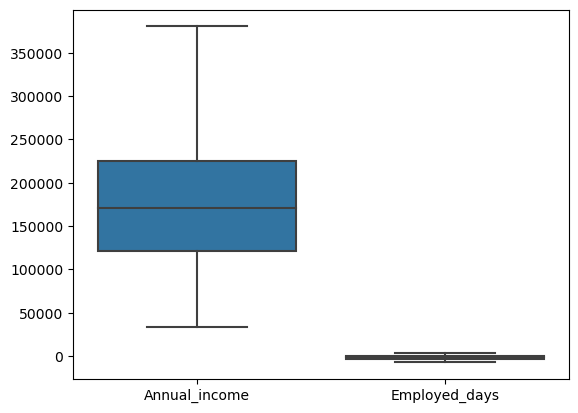

In [17]:
sns.boxplot(df[['Annual_income', 'Employed_days', ]]);

In [18]:
df.Birthday_count = df.Birthday_count.apply(lambda x: int(x/365)).abs()
df.rename(columns={'Birthday_count': 'Age', 'CHILDREN': 'Children', 'EDUCATION': 'Education'}, inplace=True)

In [19]:
df.Annual_income = df.Annual_income.astype(int)

In [20]:
df.Car_Owner = df.Car_Owner.map({'N': 0, 'Y': 1})
df.Propert_Owner = df.Propert_Owner.map({'N': 0, 'Y': 1})

In [22]:
df1 = pd.get_dummies(df, columns=['Type_Income', 'Education', 'Marital_status', 'Housing_type'], prefix=['Income', 'Education', 'Marital', 'Housing'], dtype=int)

In [23]:
features = ['Car_Owner', 'Propert_Owner', 'Children', 'Annual_income',
       'Age', 'Employed_days', 'Family_Members']

In [25]:
df1[features].corr()

,Car_Owner,Propert_Owner,Children,Annual_income,Age,Employed_days,Family_Members
Car_Owner,1.000000,0.002401,0.063467,0.237956,-0.144559,-0.071920,0.119851
Propert_Owner,0.002401,1.000000,-0.003352,0.018245,0.123753,0.088318,-0.004458
Children,0.063467,-0.003352,1.000000,0.061495,-0.278429,-0.174863,0.890248
Annual_income,0.237956,0.018245,0.061495,1.000000,-0.106604,-0.150811,0.048750
Age,-0.144559,0.123753,-0.278429,-0.106604,1.000000,0.336060,-0.265362
Employed_days,-0.071920,0.088318,-0.174863,-0.150811,0.336060,1.000000,-0.199859
Family_Members,0.119851,-0.004458,0.890248,0.048750,-0.265362,-0.199859,1.000000


# Checking Multicollinearity

In [26]:
vif = pd.DataFrame()
vif['Columns'] = df1[features].columns
vif['VIF'] = [variance_inflation_factor(df1[features].values, i) for i in range(df1[features].shape[1])]
vif

,Columns,VIF
0,Car_Owner,1.840904
1,Propert_Owner,2.892754
2,Children,5.162624
3,Annual_income,5.716143
4,Age,10.244403
5,Employed_days,1.421360
6,Family_Members,19.727097


Family_Members and Age are having VIF value over 10, it's better to remove one and again check the correlation between the features

In [27]:
df2 = df1.drop(columns='Family_Members')

In [32]:
features = ['Car_Owner', 'Propert_Owner', 'Children', 'Annual_income',
       'Age', 'Employed_days']

In [34]:
vif = pd.DataFrame()
vif['Columns'] = df2[features].columns
vif['VIF'] = [variance_inflation_factor(df2[features].values, i) for i in range(df2[features].shape[1])]
vif

,Columns,VIF
0,Car_Owner,1.766383
1,Propert_Owner,2.862773
2,Children,1.309159
3,Annual_income,5.467605
4,Age,5.377164
5,Employed_days,1.334733


We can clearly see that the label data is not balanced, the result may vary due to this, also model's can't be too perfect for predictions

In [35]:
df2.label.value_counts()

label
0    1373
1     175
Name: count, dtype: int64

In [36]:
df2[features].describe()

,Car_Owner,Propert_Owner,Children,Annual_income,Age,Employed_days
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,0.403101,0.652455,0.412791,184537.402455,43.433463,-1494.080023
std,0.490679,0.476345,0.776691,82237.507253,11.505153,2979.810969
min,0.000000,0.000000,0.000000,33750.000000,21.000000,-7288.625000
25%,0.000000,0.000000,0.000000,121500.000000,34.000000,-3174.500000
50%,0.000000,1.000000,0.000000,171000.000000,43.000000,-1565.000000
75%,1.000000,1.000000,1.000000,225000.000000,53.000000,-431.750000
max,1.000000,1.000000,14.000000,380250.000000,68.000000,3682.375000


# Data Splitting:

In [37]:
X = df2.drop(columns='label')

In [38]:
y = df2['label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Feature Scaling

In [40]:
scale = StandardScaler()
X_train.iloc[:, 3:6] = scale.fit_transform(X_train.iloc[:, 3:6])
X_test.iloc[:, 3:6] = scale.transform(X_test.iloc[:, 3:6])

In [41]:
X_train.head()

,Car_Owner,Propert_Owner,Children,Annual_income,Age,Employed_days,Income_Commercial associate,Income_Pensioner,Income_State servant,Income_Working,...,Marital_Married,Marital_Separated,Marital_Single / not married,Marital_Widow,Housing_Co-op apartment,Housing_House / apartment,Housing_Municipal apartment,Housing_Office apartment,Housing_Rented apartment,Housing_With parents
957,0,1,0,-1.244633,0.910466,0.395096,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1072,1,1,0,-0.756208,1.957223,1.717964,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
93,1,0,0,0.491990,0.997695,-0.353281,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
175,0,1,1,-1.244633,-0.049062,-1.632022,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
429,1,1,0,0.086766,-0.921360,-0.600629,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [42]:
X_test.head()

,Car_Owner,Propert_Owner,Children,Annual_income,Age,Employed_days,Income_Commercial associate,Income_Pensioner,Income_State servant,Income_Working,...,Marital_Married,Marital_Separated,Marital_Single / not married,Marital_Widow,Housing_Co-op apartment,Housing_House / apartment,Housing_Municipal apartment,Housing_Office apartment,Housing_Rented apartment,Housing_With parents
549,1,0,2,0.220643,-0.049062,-0.771972,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
270,1,1,0,1.848727,-0.659671,0.295757,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1129,0,1,0,0.220643,-1.183049,-0.160603,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
862,1,0,0,-0.376321,1.782764,1.717964,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1066,0,0,0,-0.756208,1.259385,1.717964,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0


# Model Selection:

### Model 1: Logistic Regression

In [43]:
model_1 = LogisticRegression()

### Model Training

In [44]:
model_1.fit(X_train, y_train)

LogisticRegression()

### Model Evaluation

In [45]:
model_1.score(X_test, y_test)

0.8733850129198967

In [46]:
y_pred = model_1.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[338   0]
 [ 49   0]]


The confusion matrix for model_1 shows the tp(388), fn(49), fp(0), tn(0) because of imbalance data.

### Hyperparameter Tuning:

In [165]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'], 
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(model_1, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [56]:
best_params = grid_search.best_params_

In [57]:
best_model_1 = grid_search.best_estimator_

In [58]:
best_model_1.score(X_test, y_test)

0.8733850129198967

In [59]:
y_pred = best_model_1.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[338   0]
 [ 49   0]]


### Model 2 : Decision Tree

In [61]:
model_2 = DecisionTreeClassifier()

### Model training

In [62]:
model_2.fit(X_train, y_train)

DecisionTreeClassifier()

### Model evaluation

In [63]:
model_2.score(X_test, y_test)

0.8501291989664083

In [64]:
y_pred = model_2.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[312  26]
 [ 32  17]]


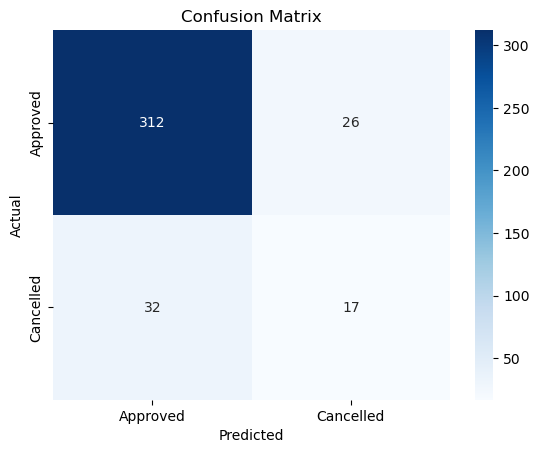

In [173]:
class_labels = ["Approved", "Cancelled"]
fig, ax = plt.subplots()
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix");

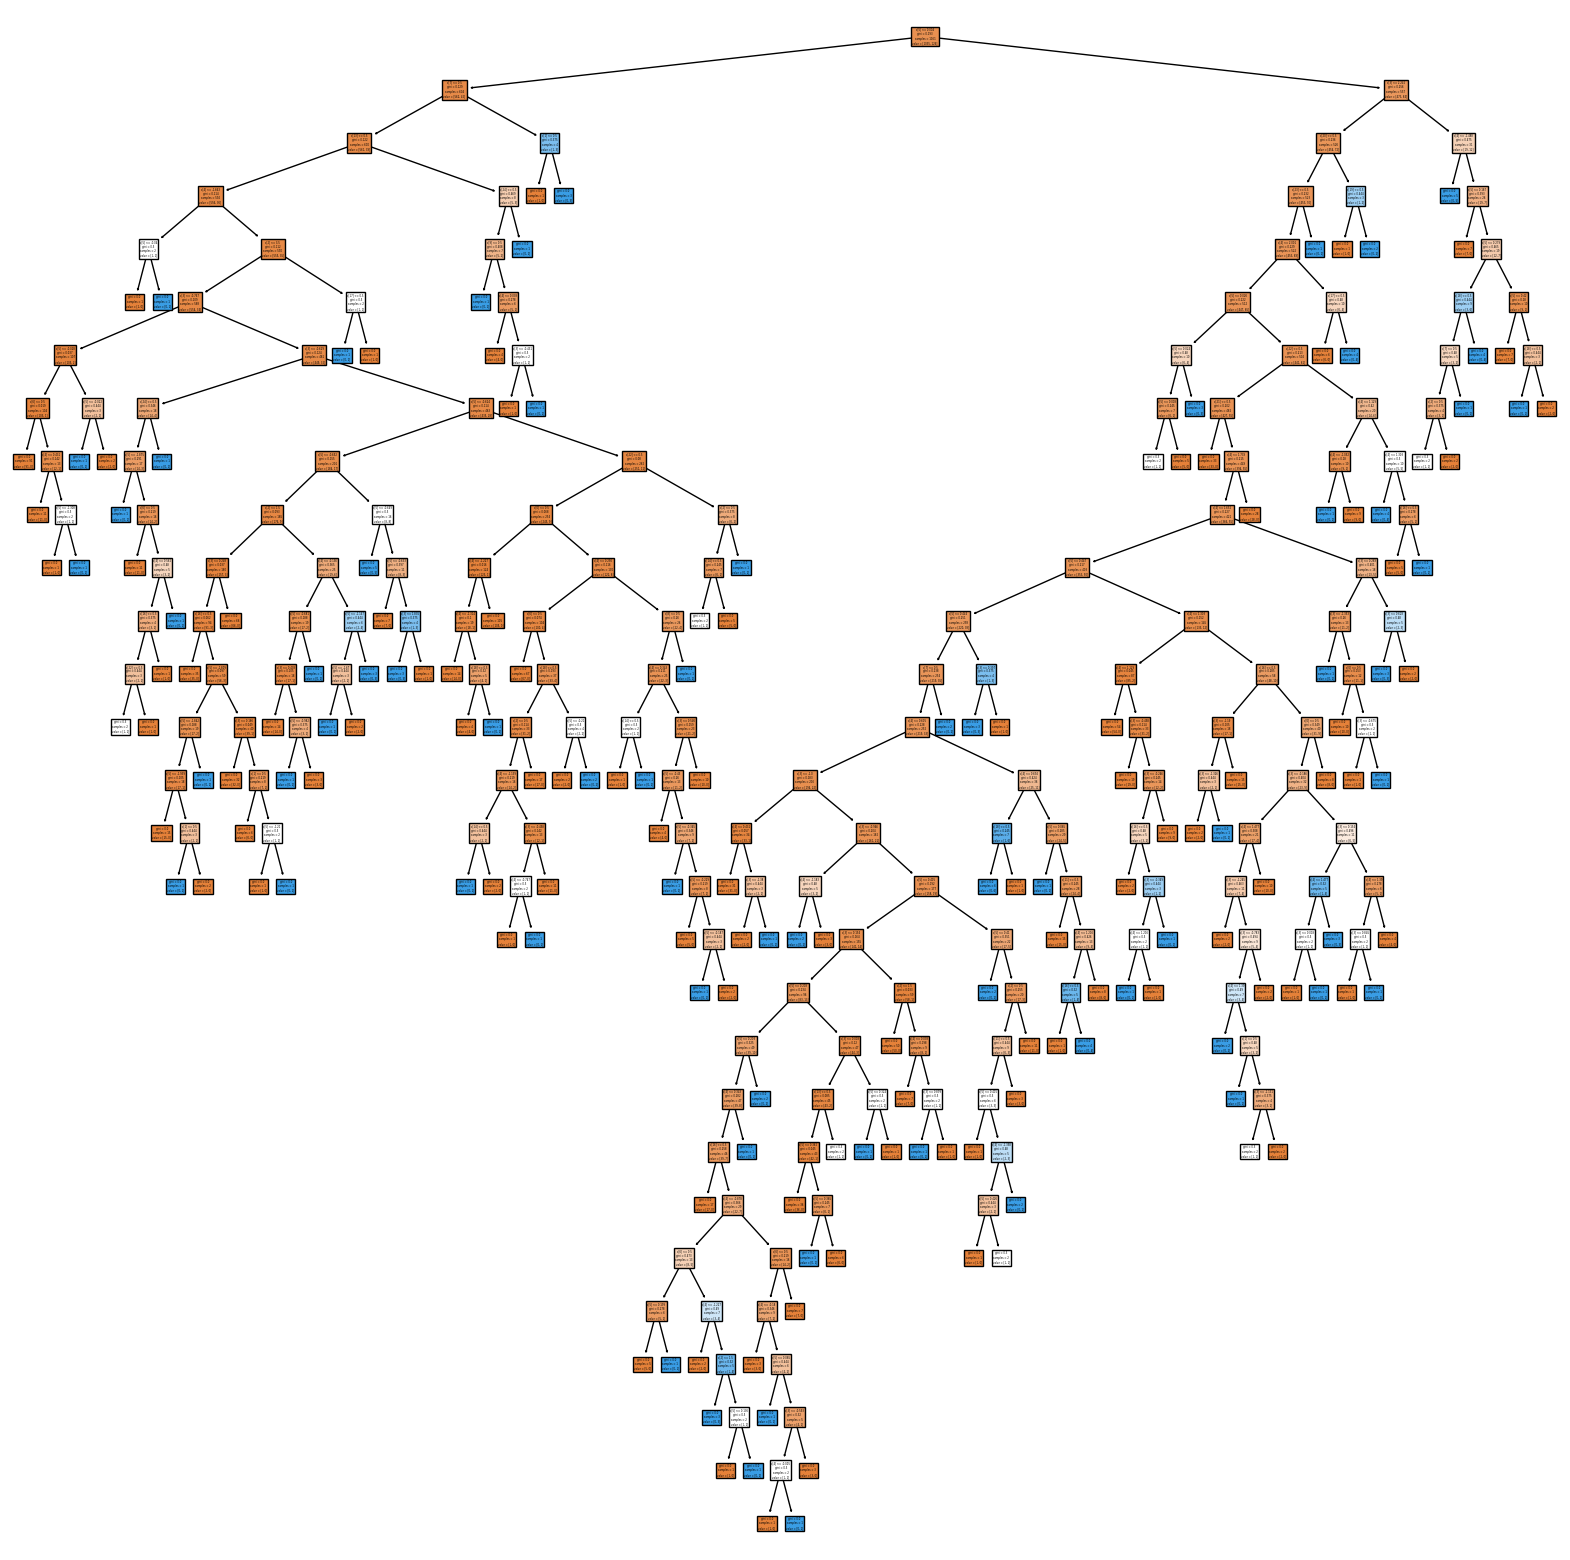

In [66]:
plt.figure(figsize=(20, 20))
tree.plot_tree(model_2, filled=True);

### Hyperparameter Tuning:

In [167]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(model_2, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [168]:
tuned_model_2 = grid_search.best_estimator_

In [169]:
tuned_model_2.score(X_test, y_test)

0.8708010335917312

In [263]:
y_pred = tuned_model_2.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[335   3]
 [ 47   2]]


For decision tree (model_2) may be overfitted, we can prune this tree using cost complexity method

### Pruning model_2 

In [174]:
pruning = model_2.cost_complexity_pruning_path(X_train, y_train)
ccp_alpha = pruning.ccp_alphas
models = []
for ccp in ccp_alpha:
    model = DecisionTreeClassifier(ccp_alpha=ccp)
    model.fit(X_train, y_train)
    models.append(model)

In [175]:
train_score = [m.score(X_train, y_train) for m in models]

In [176]:
test_score = [m.score(X_test, y_test) for m in models]

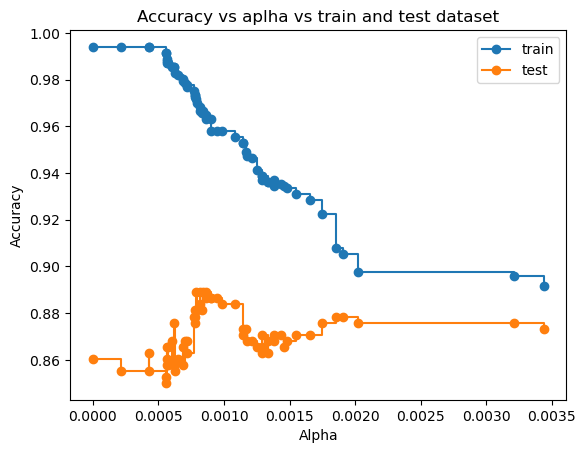

In [177]:
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs aplha vs train and test dataset")
ax.plot(ccp_alpha, train_score, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alpha, test_score, marker='o', label='test', drawstyle='steps-post')
ax.legend();

In [184]:
best_accuracy = 0
best_pruned_model_2 = None
for pruned_tree in models:
    y_pred = pruned_tree.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model_2 = pruned_tree

In [185]:
best_accuracy

0.8888888888888888

In [186]:
best_pruned_model_2

DecisionTreeClassifier(ccp_alpha=0.0007895492391616424)

In [187]:
best_pruned_model_2.score(X_test, y_test)

0.8888888888888888

In [188]:
y_pred = best_pruned_model_2.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[329   9]
 [ 34  15]]


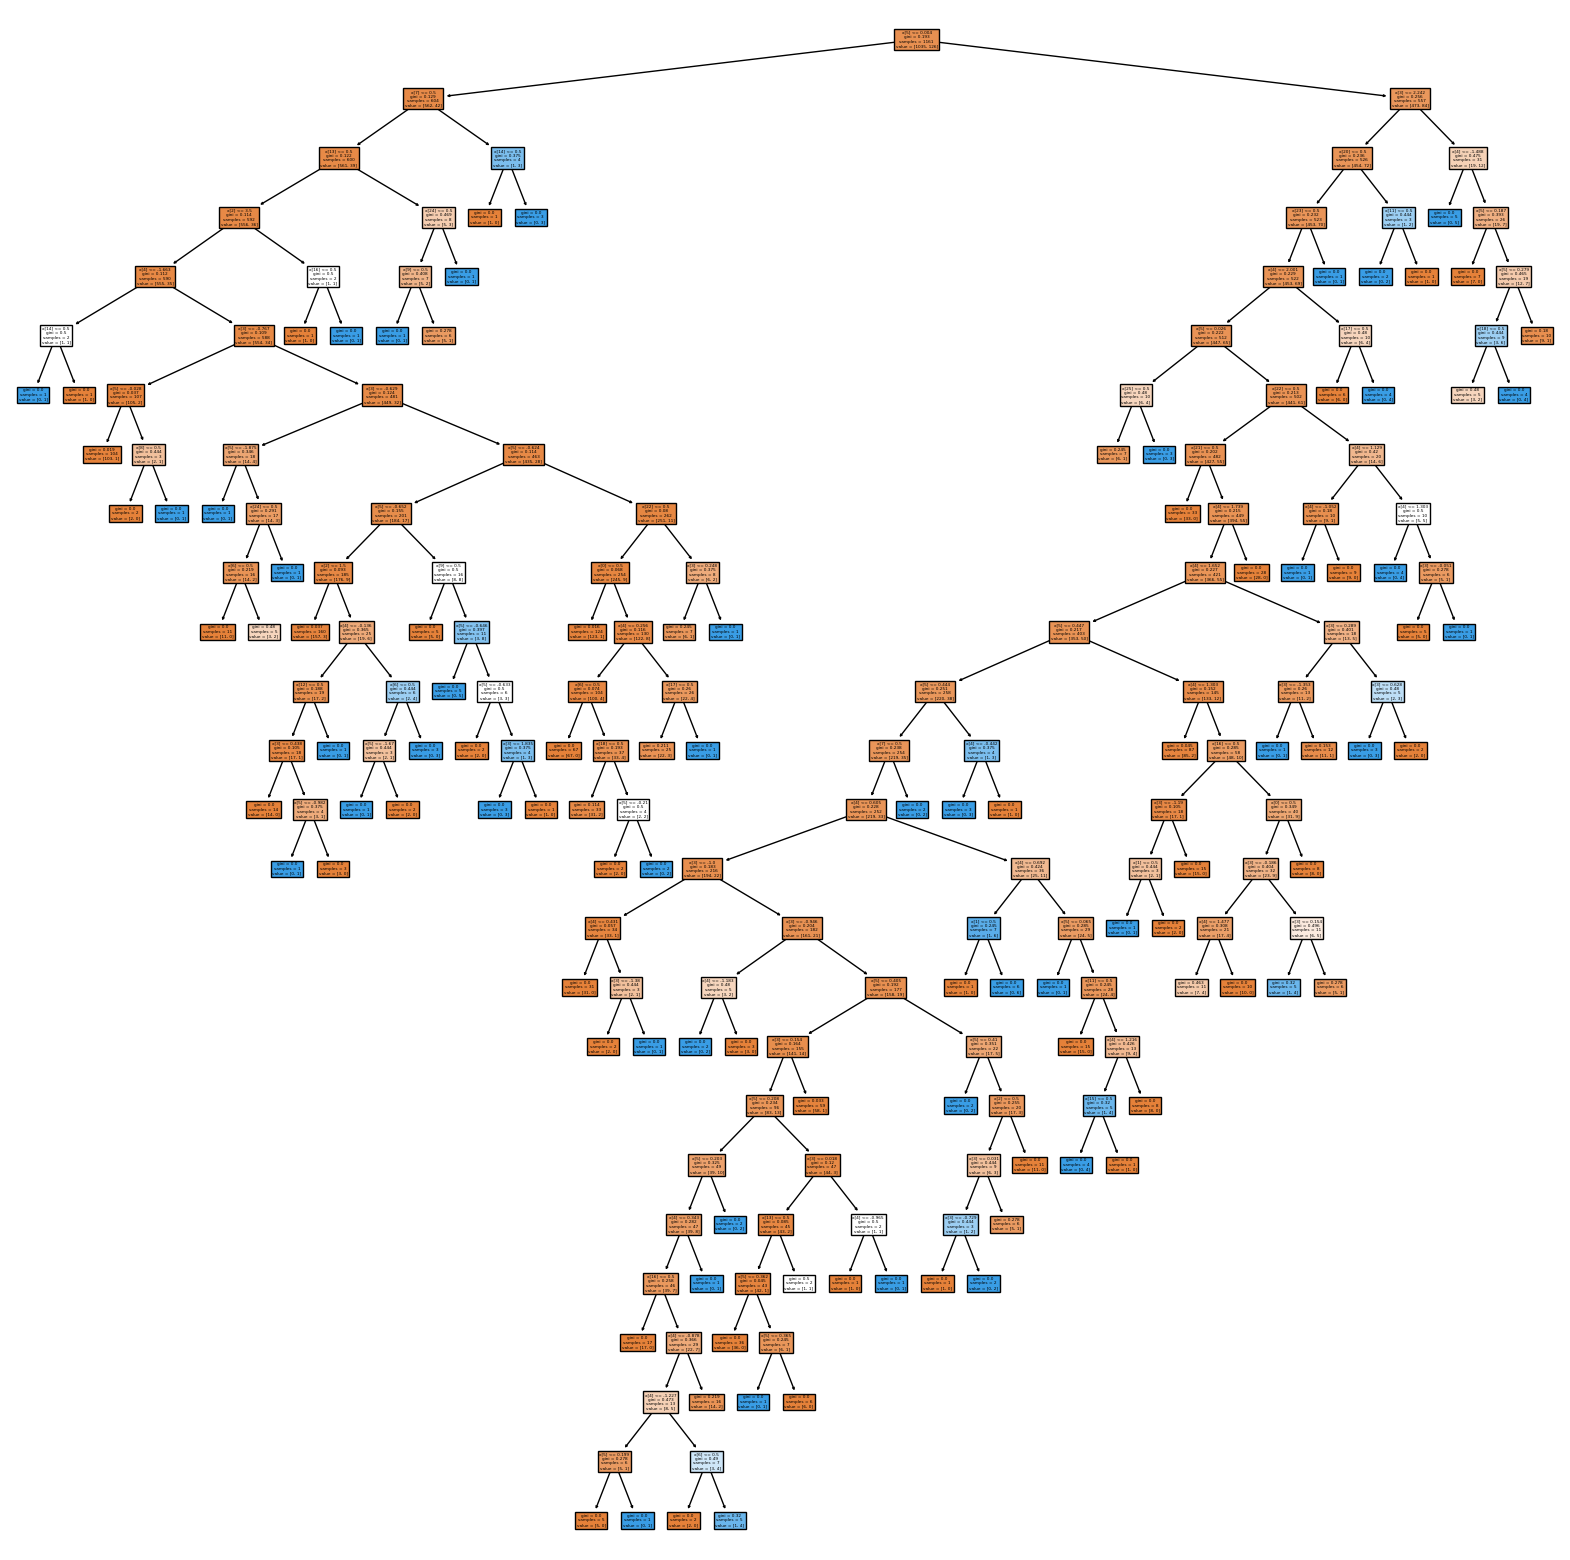

In [189]:
plt.figure(figsize=(20, 20))
tree.plot_tree(best_pruned_model_2, filled=True);

### Hyperparameter tuining for best pruned tree

In [190]:
grid_para = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_ccp = GridSearchCV(estimator=best_pruned_model_2, param_grid=grid_para, cv= 5)

In [191]:
grid_ccp.fit(X_test, y_test)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0007895492391616424),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [193]:
best_pruned_tuned_model_2 = grid_ccp.best_estimator_

In [194]:
best_pruned_tuned_model_2.score(X_test, y_test)

0.8863049095607235

In [195]:
y_pred = best_pruned_tuned_model_2.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[336   2]
 [ 42   7]]


['Car_Owner',
 'Propert_Owner',
 'Children',
 'Annual_income',
 'Age',
 'Employed_days',
 'Income_Commercial associate',
 'Income_Pensioner',
 'Income_State servant',
 'Income_Working',
 'Education_Academic degree',
 'Education_Higher education',
 'Education_Incomplete higher',
 'Education_Lower secondary',
 'Education_Secondary / secondary special',
 'Marital_Civil marriage',
 'Marital_Married',
 'Marital_Separated',
 'Marital_Single / not married',
 'Marital_Widow',
 'Housing_Co-op apartment',
 'Housing_House / apartment',
 'Housing_Municipal apartment',
 'Housing_Office apartment',
 'Housing_Rented apartment',
 'Housing_With parents']

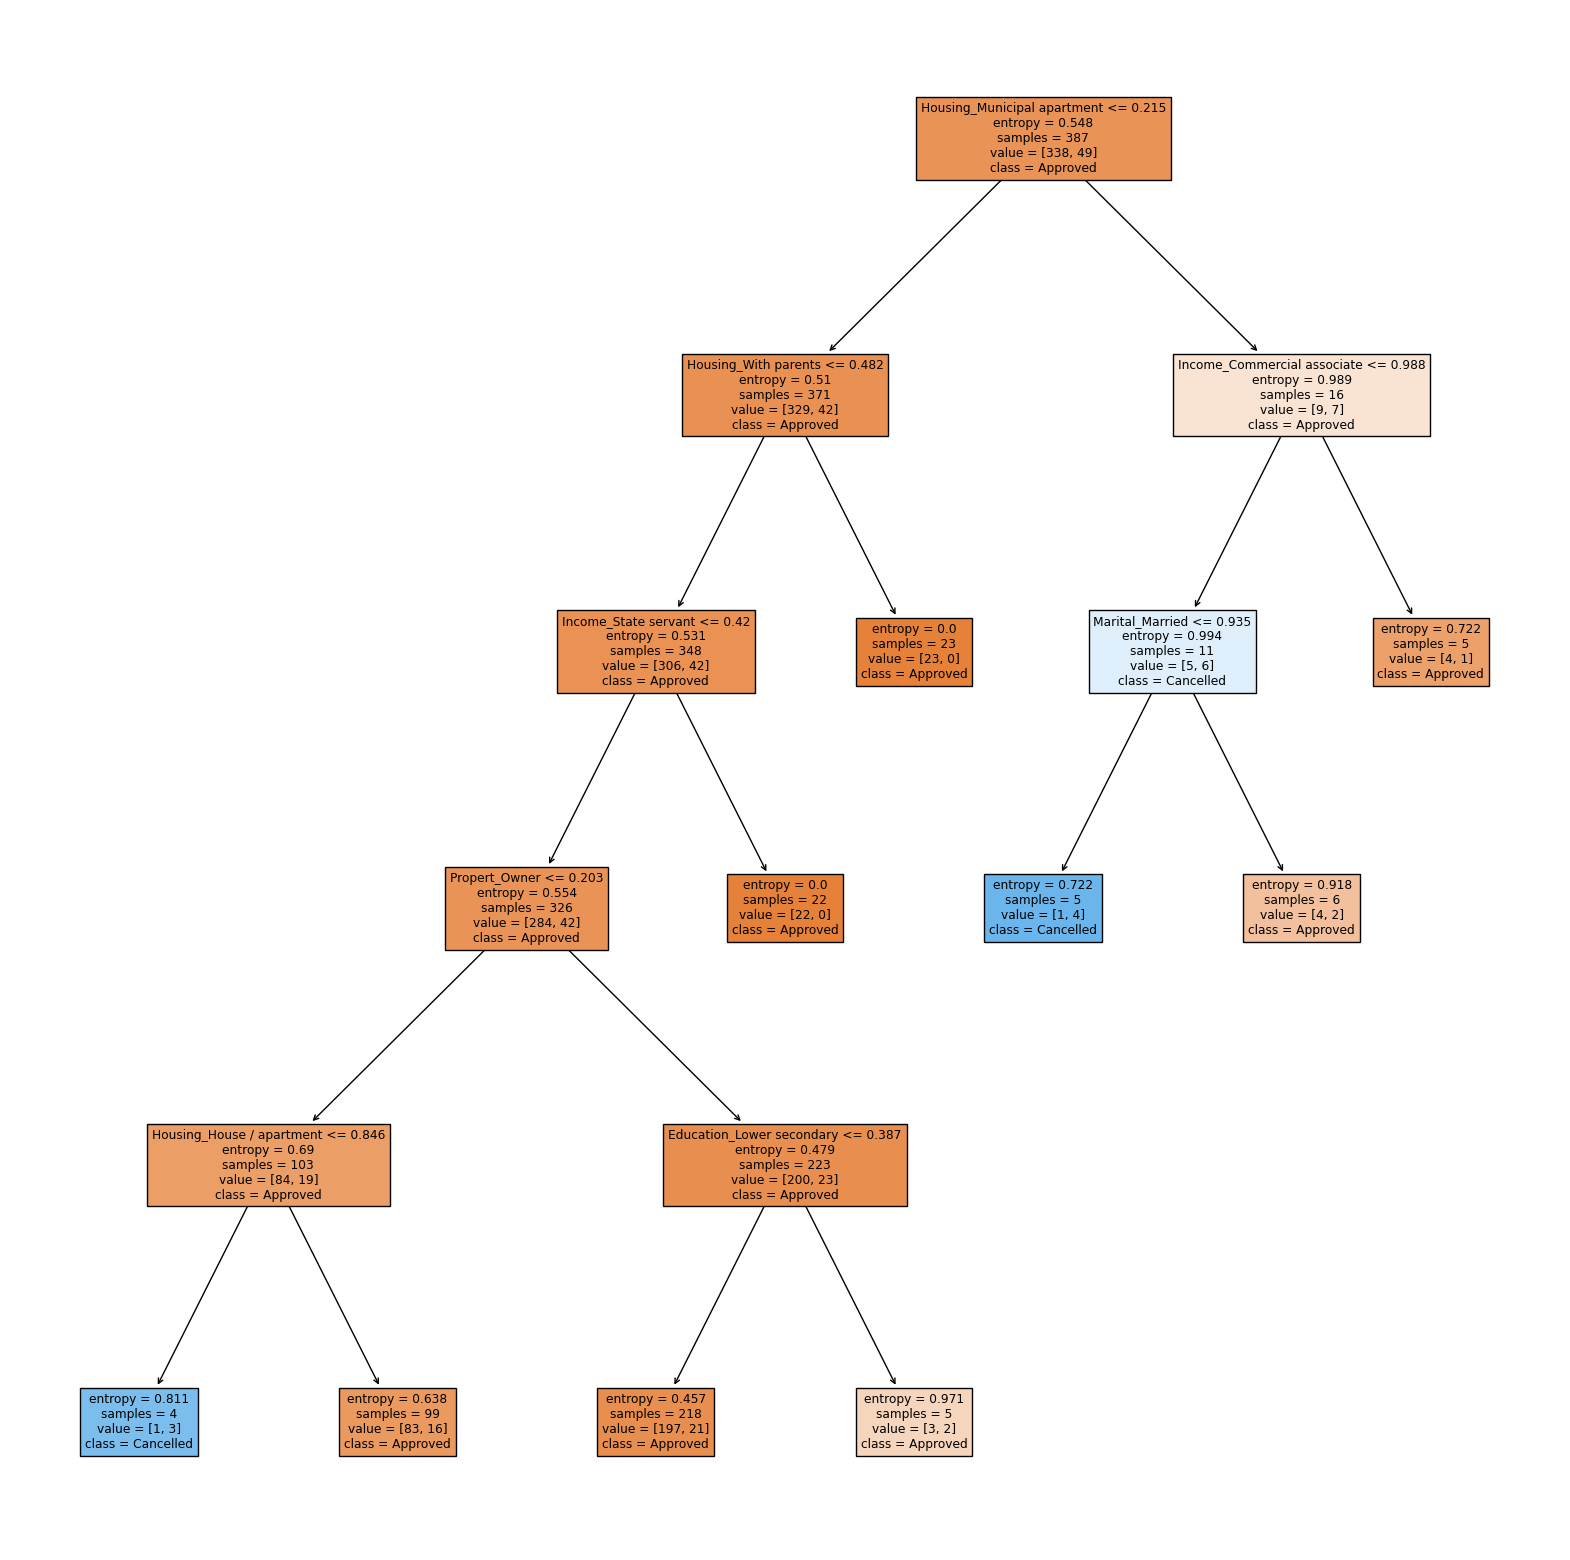

In [201]:
plt.figure(figsize=(20, 20))
tree.plot_tree(best_pruned_tuned_model_2, filled=True, feature_names=X.columns.tolist(), 
               class_names=['Approved', 'Cancelled']);

In [202]:
scores = cross_val_score(best_pruned_tuned_model_2, X_train, y_train, cv=5)
clf_df = pd.DataFrame({'tree': range(5), 'accuracy': scores})

<Axes: xlabel='tree'>

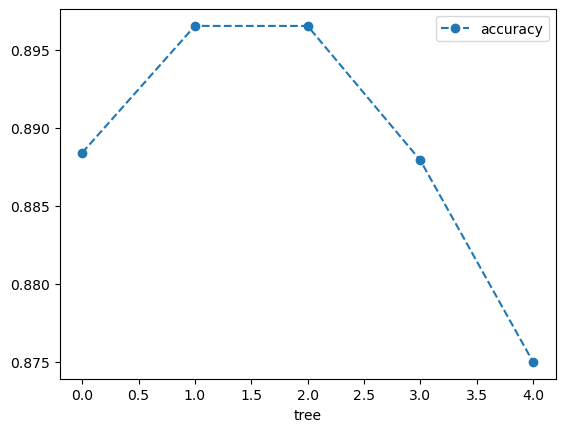

In [203]:
clf_df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

In [204]:
pruning = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alpha = pruning.ccp_alphas
alpha_values = []
for ccp in ccp_alpha:
    model = DecisionTreeClassifier(ccp_alpha=ccp)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    alpha_values.append([ccp, np.mean(scores), np.std(scores)])

<Axes: xlabel='alpha'>

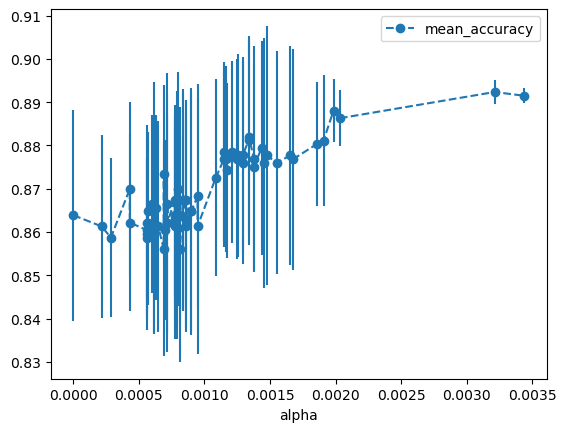

In [205]:
alpha_result = pd.DataFrame(alpha_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_result.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [209]:
alpha_result[(alpha_result.alpha > 0.0030) & (alpha_result.alpha < 0.0034)]

,alpha,mean_accuracy,std
63,0.003212,0.892334,0.002732


In [206]:
alpha_result.alpha.max()

0.003437404472738196

In [207]:
ccp_value = alpha_result[(alpha_result.alpha > 0.0034) & (alpha_result.alpha < 0.0040)].alpha
ccp_value = float(ccp_value.iloc[0])
ccp_value

0.003437404472738196

In [208]:
clf_dt_pruned = DecisionTreeClassifier(ccp_alpha=ccp_value)
clf_dt_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.003437404472738196)

In [210]:
clf_dt_pruned.score(X_test, y_test)

0.8733850129198967

In [211]:
y_pred = clf_dt_pruned.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[338   0]
 [ 49   0]]


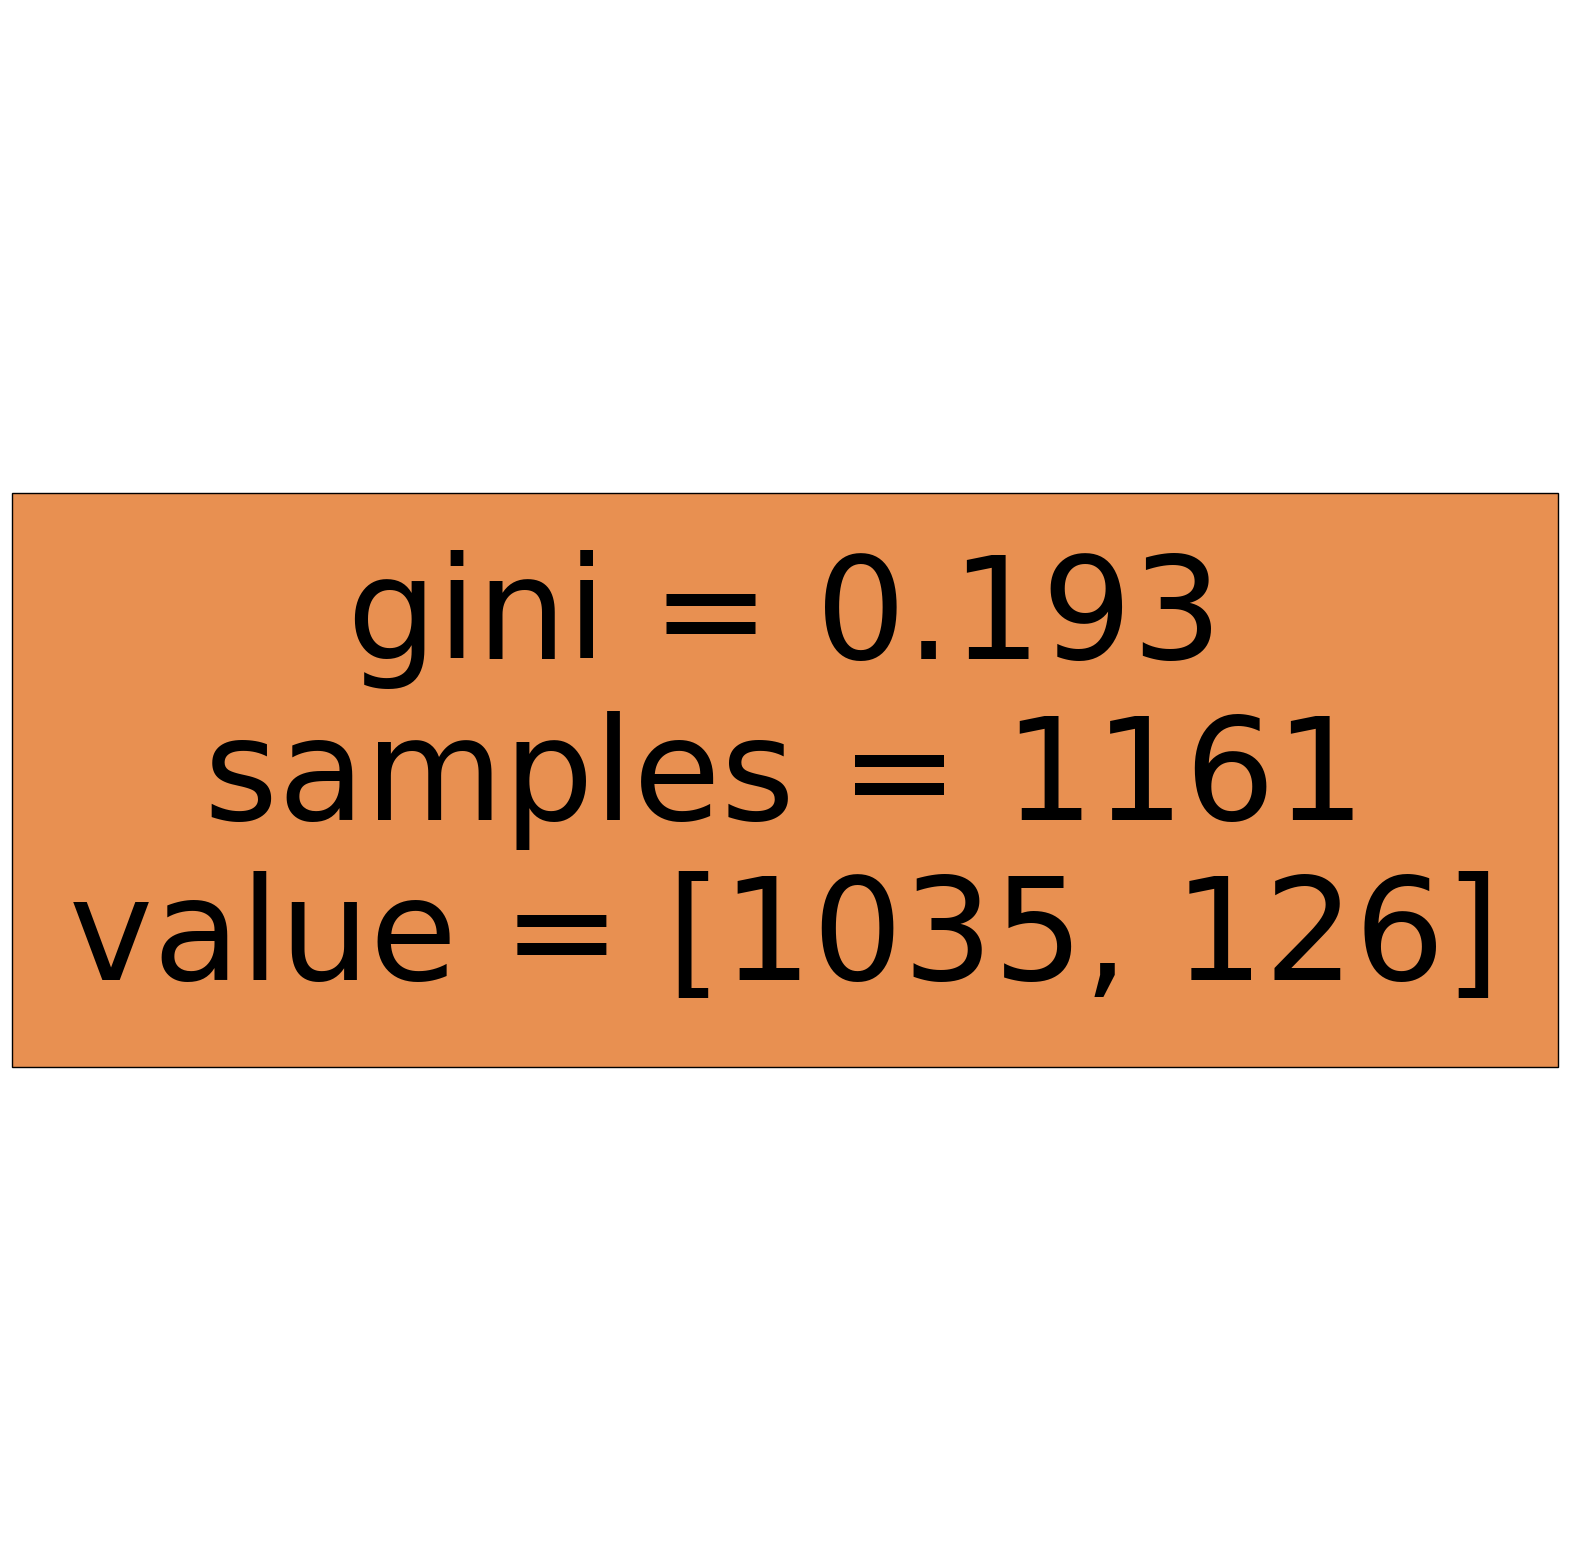

In [212]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_dt_pruned, filled=True);

### model 3: Random Forest (Bagging Ensemble Technique)

In [125]:
model_3 = RandomForestClassifier()

### Model training

In [126]:
model_3.fit(X_train, y_train)

RandomForestClassifier()

### Model evaluation

In [127]:
model_3.score(X_test, y_test)

0.9043927648578811

In [128]:
y_pred = model_3.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[336   2]
 [ 35  14]]


In [241]:
len(model_3.estimators_)

100

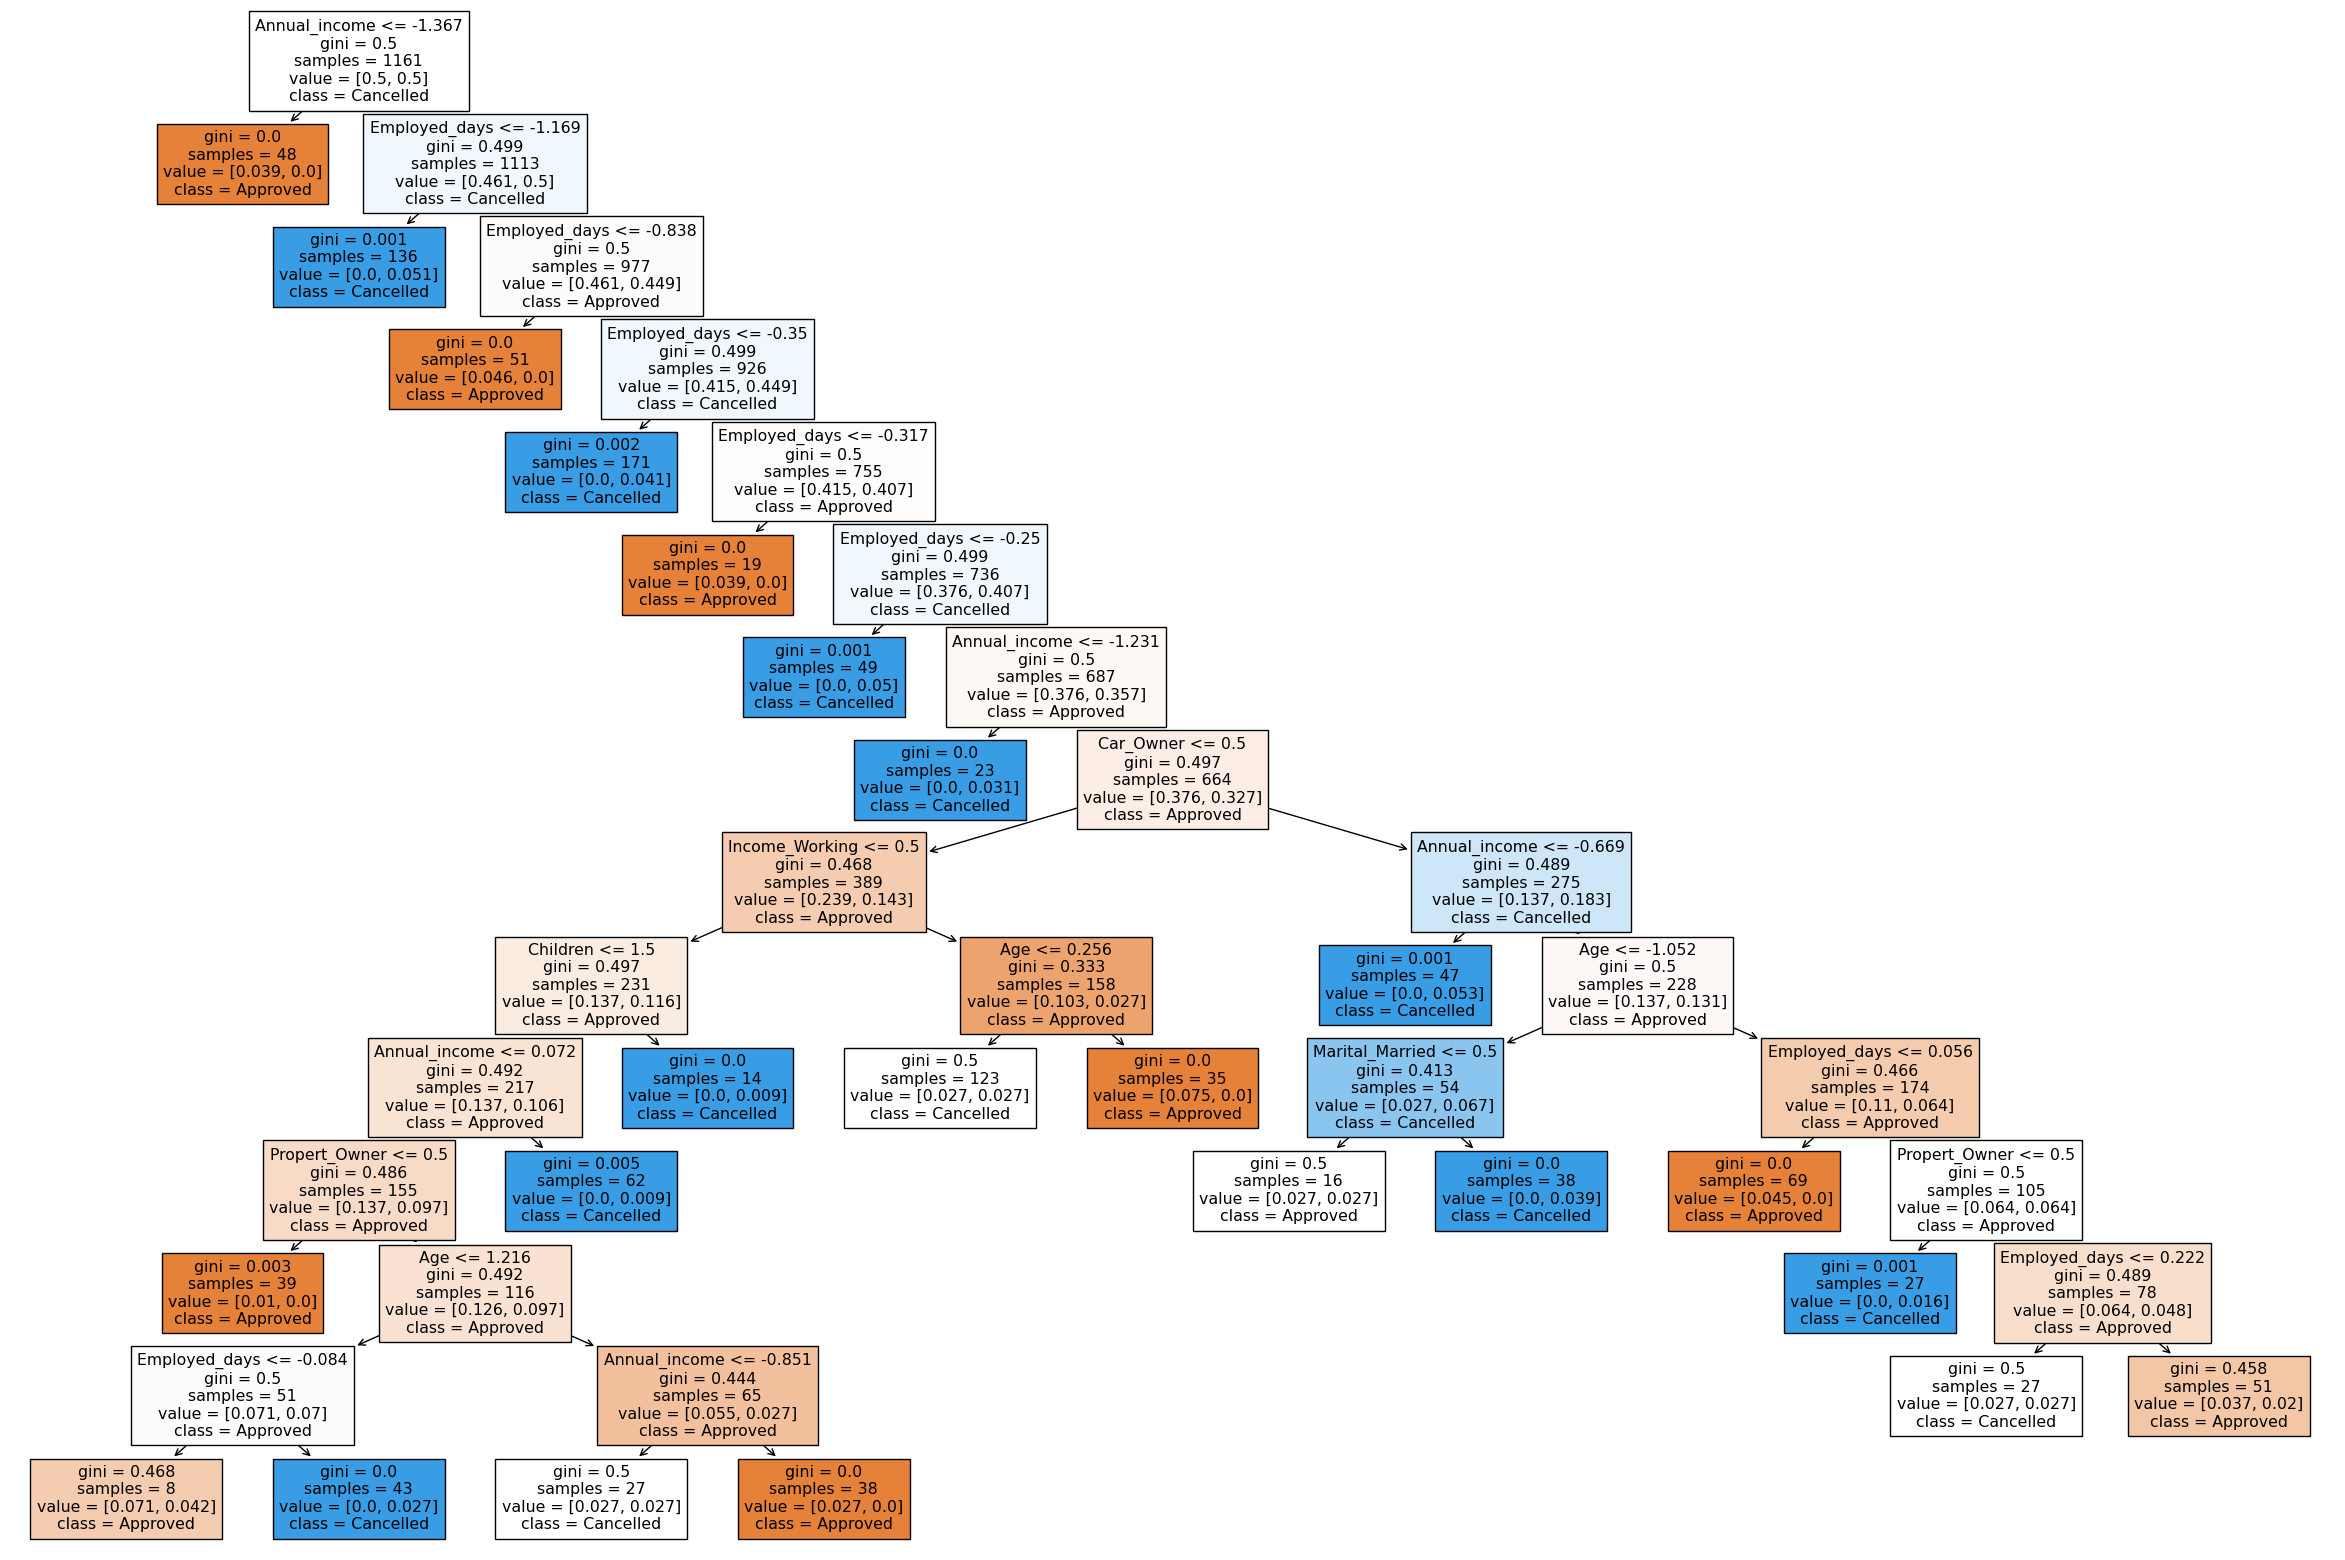

In [230]:
plt.figure(figsize=(30, 20))
tree.plot_tree(model_4.estimators_[2], filled=True, feature_names=X.columns.tolist(), 
               class_names=['Approved', 'Cancelled']);

### Hyperparameter Tuning:

In [231]:
grid_para = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
gridSearchCV = GridSearchCV(estimator=model_3, param_grid=grid_para, cv= 5)
gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [232]:
tuned_model_3 = gridSearchCV.best_estimator_

In [233]:
tuned_model_3.score(X_test, y_test)

0.896640826873385

In [234]:
y_pred = tuned_model_3.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[337   1]
 [ 39  10]]


### Model 4 : Adaptive Boosting (Boosting Ensemble Technique) 

In [276]:
model_4 = AdaBoostClassifier(estimator=None)

### Model training

In [277]:
model_4.fit(X_train, y_train)

AdaBoostClassifier()

### Model Evaluation

In [278]:
model_4.score(X_test, y_test)

0.8733850129198967

In [279]:
y_pred = model_4.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[336   2]
 [ 47   2]]


### Hyperparameter Tuning

In [282]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [None],
}

grid_search = GridSearchCV(model_4, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'estimator': [None], 'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [283]:
best_tuned_model_4 = grid_search.best_estimator_

In [284]:
best_tuned_model_4.score(X_test, y_test)

0.8733850129198967

In [285]:
y_pred = best_tuned_model_4.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[338   0]
 [ 49   0]]


# Conclusion:

The Credit Worthiness project was a significant endeavor where we explored various machine learning models to assess and predict creditworthiness. Among the models evaluated, Random Forest emerged as the standout performer, achieving an impressive accuracy of 90% on the testing dataset. This exceptional result underscores the robustness and effectiveness of the Random Forest algorithm in accurately identifying creditworthy applicants. The success of this project not only enhances our decision-making capabilities but also reaffirms the importance of leveraging advanced machine learning techniques in the realm of credit assessment.

In [289]:
tabel1 = pd.read_csv('Credit_card.csv')
tabel2 = pd.read_csv('Credit_card_label.csv')

In [297]:
credit_card = pd.merge(left=tabel1, right=tabel2, how='inner', on='Ind_ID')

In [301]:
credit_card.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


In [299]:
import duckdb
conn=duckdb.connect()
conn.register('credit_card', credit_card)

In [303]:
conn.execute("select * from credit_card").fetchdf()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,None,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,None,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,None,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,None,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,None,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


- 1. Group the customers based on their income type and find the average of their annual income

In [304]:
query_1 = "select Ind_ID, avg(Annual_income) from credit_card group by 1"
conn.execute(query_1).fetchdf()

,Ind_ID,avg(Annual_income)
0,5022053,202500.0
1,5024916,112500.0
2,5033916,180000.0
3,5036590,292500.0
4,5045895,225000.0
...,...,...
1543,5062334,94500.0
1544,5105069,157500.0
1545,5096856,180000.0
1546,5089719,144000.0


- 2. Find the female owners of cars and property.

In [306]:
query_2 = "select Car_Owner, Propert_Owner from credit_card where GENDER='F'"
conn.execute(query_2).fetchdf()

,Car_Owner,Propert_Owner
0,Y,N
1,Y,N
2,Y,N
3,Y,N
4,Y,N
...,...,...
968,Y,Y
969,N,Y
970,N,Y
971,N,N


- 3.Find the male customers who are staying with their families.

In [ ]:
query_3 = "select Car_Owner, Propert_Owner from credit_card where GENDER='F'"
conn.execute(query_3).fetchdf()

- 4.Please list the top five people having the highest income.

In [321]:
query_4 = """with result as 
(select Ind_ID, Annual_income, dense_rank() over(order by Annual_income desc)  
as rnk from credit_card)
select * from result where rnk <=5"""
conn.execute(query_4).fetchdf()

,Ind_ID,Annual_income,rnk
0,5143231,1575000.0,1
1,5143235,1575000.0,1
2,5090470,900000.0,2
3,5079016,900000.0,2
4,5079017,900000.0,2
5,5116005,900000.0,2
6,5148669,810000.0,3
7,5067653,787500.0,4
8,5090166,675000.0,5


- 5.How many married people are having credit card?

In [325]:
query_5 = "select count(*) as count from credit_card where Marital_status='Married' and label=1"
conn.execute(query_5).fetchdf()

,count
0,114


- 6.What is the highest education level and what is the total count?

In [328]:
query_6 = "select count(*) count from credit_card where EDUCATION='Higher education'"
conn.execute(query_6).fetchdf()

,count
0,426


- 7.Between married males and females, who is having more credit card? 

In [329]:
query_7 = "select GENDER from credit_card where Marital_status='Married' and label=1 group by 1"
conn.execute(query_7).fetchdf()

,GENDER
0,None
1,M
2,F
